Notes
- Do we want a column for date (or days since start)?
- Do we want to standardize by date? 
- The heck is happening with PC
- Can the last few days go in test?

In [113]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
import tensorflow as tf

# ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/github/'
# ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/jupyteruser/31170133/github/'
os.chdir(ts_dir)


In [114]:
# # Only run if us_mobility.csv hasn't been created or needs updating 

# global_mob = pd.read_csv('../Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('us_mobility.csv', index = False)

In [115]:
mob = pd.read_csv('data/us_mobility.csv')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()


,state,county,date,retail,grocery,parks,transit,work,residential
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [116]:
nyt = pd.read_csv(f'data/us-counties.csv').drop(columns = 'fips')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [117]:
### TODO: match by county better
mobcounties = mob.county.unique()
nytcounties = nyt.county.unique()
print(len([c for c in mobcounties if c not in nytcounties]))
print(len([c for c in nytcounties if c not in mobcounties]))

118
123


In [118]:
mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [119]:
mob['ID'] = mob.groupby(['state']).ngroup() # reset ID to identify a state
mob = mob.groupby(['state', 'ID', 'date']).agg(
    retail = ('retail', np.mean),
    grocery = ('grocery', np.mean),
    work = ('work', np.mean),
    cases = ('cases', sum),
    deaths =('deaths', sum)).reset_index()

In [120]:
pop = pd.read_csv('data/statepop.csv')
pop.rename(columns = {'NAME':'state', 'POPESTIMATE2019':'pop'}, inplace = True)
pop = pop.loc[pop.state.isin(mob.state.unique()), ['state','pop']]
mob = mob.merge(pop, how = 'left', on = 'state')
mob['casespc'] = 100000*mob['cases']/mob['pop'] # cases per 100k
mob['logcasespc'] = np.log(1 + mob['casespc'])
mob.head()

,state,ID,date,retail,grocery,work,cases,deaths,pop,casespc,logcasespc
0,Alabama,0,2020-02-15,5.157895,0.203125,0.760000,0.0,0.0,4903185,0.0,0.0
1,Alabama,0,2020-02-16,-1.481481,-4.047619,-1.938776,0.0,0.0,4903185,0.0,0.0
2,Alabama,0,2020-02-17,-1.241379,-4.548387,-16.253731,0.0,0.0,4903185,0.0,0.0
3,Alabama,0,2020-02-18,-4.285714,-5.031746,0.328358,0.0,0.0,4903185,0.0,0.0
4,Alabama,0,2020-02-19,1.392857,-0.758065,1.402985,0.0,0.0,4903185,0.0,0.0


In [121]:
# Decide whether to keep counties and columns based on response rates
## TODO: Add Alaska

# pick columns
cats = ['grocery','retail','work'] # note: only use these categories for building PCs

# pick rows/counties
mob['ID'] = mob.groupby(['state']).ngroup() # assign each county an ID
missingrates = mob.groupby(['state','ID'])[cats].agg(lambda x: np.mean(pd.isnull(x))).reset_index() # missing rates by column for cats
allowance = 0.35 # what percent you're allowed to have missing without getting cut (check distplots of missingrates for reasonable cutoff)
keeper_IDs = missingrates.loc[(missingrates[cats] < allowance).sum(1) == 3, 'ID'].values # IDs of counties with all 3 under allowance
mob = mob[mob['ID'].isin(keeper_IDs)] # only keep those ones
mob.fillna(mob.groupby(['ID','state'])[cats].transform('median'), inplace = True) # fill in with median for group
mob = mob.loc[mob.groupby('ID')['casespc'].transform(lambda x: np.mean(pd.isnull(x))) == 0] # remove counties with missing cases pc ## CULPRIT 
mob.reset_index(inplace = True, drop = True)



In [123]:
# divide
dates = mob.date.unique()
ndates = len(dates)
upto = dates[int(0.8*ndates)]
mobtest = mob[mob['date'] > upto]
mob = mob[mob['date'] <= upto]


#### Get metric of mobility

In [124]:
## Standardize
ss = SS().fit(mob[cats]) 
mobstand = ss.transform(mob[cats])
mobteststand = ss.transform(mobtest[cats])

## Add to mobility and mobilitytest
mob[cats] = pd.DataFrame(mobstand, columns = cats, index = mob.index)
mobtest[cats] = pd.DataFrame(mobteststand, columns = cats, index = mobtest.index)


#### Baseline Model

In [125]:
target = 'logcasespc'
predictors = cats + [target]
predictors

['grocery', 'retail', 'work', 'logcasespc']

In [126]:
nback = 10 # means each prediction will look back nback timesteps
nahead = 3 # means each prediction will be for up to nahead steps ahead
grouped = mob.groupby(['state','ID'])
county_lens = grouped.apply(len).values
nsamples = sum(np.maximum(county_lens - (nback + nahead - 1), 0)) # counts total number of samples we need # note that if it's shorter than nahead + nback, skip it 


In [127]:
# only run the commented out stuff if X/y/states/counties aren't already saved
X = np.empty((nsamples, nback, len(predictors)))
y = np.empty((nsamples, nahead))
states = []
# counties = []

index = 0
for (state, ID), data in grouped:
    if len(data) < nback + nahead:
        continue
    for i in range(nback, len(data) - nahead + 1): 
        X[index] = data.iloc[i-nback: i][predictors]
        y[index] = data[target].iloc[i:i + nahead]
        states.append(state)
#         counties.append(county)
        index += 1
states = np.array(states)
# counties = np.array(counties)

In [129]:
# np.savetxt(f'models/X.csv',X.reshape(nsamples, -1), delimiter = ',')
# np.savetxt(f'models/y.csv', y, delimiter = ',')
# np.savetxt(f'models/states.csv', states, delimiter = ',', fmt = '%s')
# np.savetxt(f'models/counties.csv', counties, delimiter = ',', fmt = '%s')

In [130]:
# X = np.loadtxt(f'models/X.csv', delimiter = ',').reshape(nsamples, nback, len(predictors))
# y = np.loadtxt(f'models/y.csv', delimiter = ',')
# states = np.loadtxt(f'models/states.csv', delimiter = ',', dtype = str)
# counties = np.loadtxt(f'models/counties.csv', delimiter = ',', dtype = str)

In [131]:
nunits = 500
interunits = 100
droprate = 0.15
optimizer = optimizers.Adam(learning_rate = 0.00005)


inputs = Input(shape = (nback, len(predictors)), name = 'inputs')
layer = LSTM(units = nunits, return_sequences = False, name = 'lstm1', activation = 'tanh')(inputs)
layer = Dropout(rate = droprate, name = 'drop1')(layer)
layer = Dense(interunits, activation = 'relu', name = 'inters')(layer)
outputs = Dense(nahead, activation = 'relu', name = 'outputs')(layer)
mod = Model(inputs, outputs, name = 'mod')
mod.compile(optimizer, loss = 'mean_squared_error')
mod.summary()

Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 10, 4)]           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 500)               1010000   
_________________________________________________________________
drop1 (Dropout)              (None, 500)               0         
_________________________________________________________________
inters (Dense)               (None, 100)               50100     
_________________________________________________________________
outputs (Dense)              (None, 3)                 303       
Total params: 1,060,403
Trainable params: 1,060,403
Non-trainable params: 0
_________________________________________________________________


In [132]:
epochs = 40
batch_size = 32
validation_split = 0.15
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2)]
verbose = 2

history = mod.fit(X,
                  y,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_split = validation_split,
                  callbacks = callbacks,
                  verbose = verbose)



Train on 1473 samples, validate on 261 samples
Epoch 1/40
1473/1473 - 3s - loss: 1.7482 - val_loss: 1.5501
Epoch 2/40
1473/1473 - 0s - loss: 0.8808 - val_loss: 0.2280
Epoch 3/40
1473/1473 - 0s - loss: 0.1141 - val_loss: 0.1520
Epoch 4/40
1473/1473 - 0s - loss: 0.0934 - val_loss: 0.1209
Epoch 5/40
1473/1473 - 0s - loss: 0.0852 - val_loss: 0.1007
Epoch 6/40
1473/1473 - 0s - loss: 0.0813 - val_loss: 0.0997
Epoch 7/40
1473/1473 - 0s - loss: 0.0792 - val_loss: 0.0881
Epoch 8/40
1473/1473 - 0s - loss: 0.0739 - val_loss: 0.0806
Epoch 9/40
1473/1473 - 0s - loss: 0.0743 - val_loss: 0.0781
Epoch 10/40
1473/1473 - 0s - loss: 0.0686 - val_loss: 0.0768
Epoch 11/40
1473/1473 - 0s - loss: 0.0655 - val_loss: 0.0684
Epoch 12/40
1473/1473 - 0s - loss: 0.0677 - val_loss: 0.0892
Epoch 13/40
1473/1473 - 0s - loss: 0.0601 - val_loss: 0.0636
Epoch 14/40
1473/1473 - 0s - loss: 0.0612 - val_loss: 0.0702
Epoch 15/40
1473/1473 - 0s - loss: 0.0569 - val_loss: 0.0500
Epoch 16/40
1473/1473 - 0s - loss: 0.0535 - val

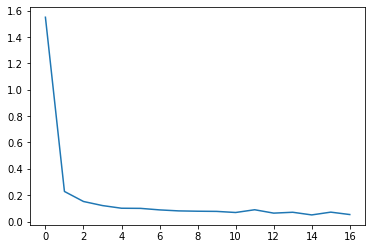

In [133]:
sns.lineplot(range(len(history.history['val_loss'])), history.history['val_loss']);

In [79]:
# mod.save(f'models/mod.h5')  
# mod = load_model(f'models/mod.h5')

In [134]:
yhat = mod.predict(X)

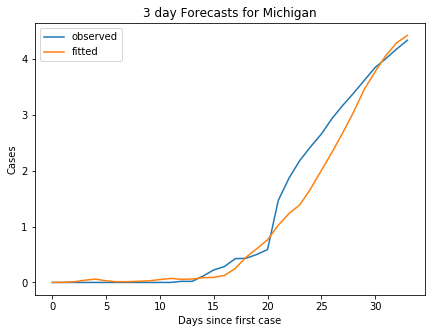

In [135]:
state = 'Michigan'


statey = y[states == state]
stateyhat = yhat[states == state]
state_obs = len(statey)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(state_obs), statey[:,d], label = 'observed')
sns.lineplot(range(state_obs), stateyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {state}');



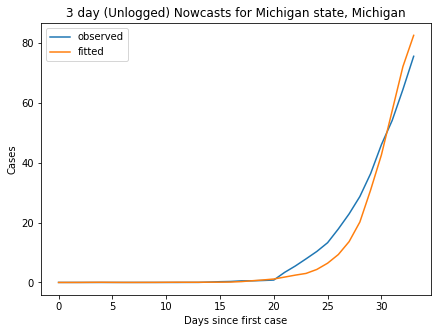

In [136]:
statey = np.exp(y[(states == state)]) - 1
stateyhat = np.exp(yhat[(states == state)]) -1
state_obs = len(statey)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(state_obs), statey[:,d], label = 'observed')
sns.lineplot(range(state_obs), stateyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since first case', ylabel = 'Cases', title = f'{d + 1} day (Unlogged) Nowcasts for {state}');




In [137]:
joint = mobtest.append(mob).sort_values(['ID','date'])
joint = joint[joint['date'] >= upto - np.timedelta64(nback - 1, 'D')] # only go to nback days before training ends (that way you're not predicitng any training)

# same thing but this time it's for joint
grouped = joint.groupby(['state','ID'])
county_lens = grouped.apply(len).values
nsamples = sum(np.maximum(county_lens - (nback + nahead - 1), 0)) # counts total number of samples we need # note that if it's shorter than nahead + nback, skip it 

In [138]:
# only run the commented out stuff if X/y/states/counties aren't already saved
Xtest = np.empty((nsamples, nback, len(predictors)))
ytest = np.empty((nsamples, nahead))
statestest = []

index = 0
for (state, ID), data in grouped:
    if len(data) < nback + nahead:
        continue
    for i in range(nback, len(data) - nahead + 1): 
        Xtest[index] = data.iloc[i-nback: i][predictors]
        ytest[index] = data[target].iloc[i:i + nahead]
        statestest.append(state)
#         countiestest.append(county)
        index += 1
statestest = np.array(statestest)


In [139]:
# np.savetxt(f'models/Xtest.csv',Xtest.reshape(nsamples, -1), delimiter = ',')
# np.savetxt(f'models/ytest.csv', ytest, delimiter = ',')

In [140]:
yhattest = mod.predict(Xtest)

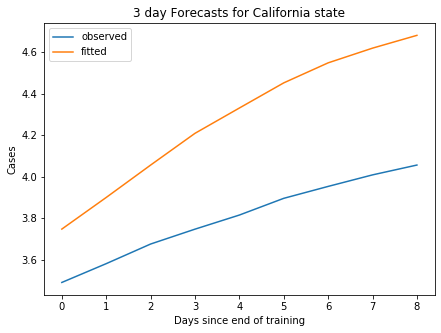

In [141]:
# county = 'Contra Costa'
state = 'California'


statey = ytest[statestest == state]
stateyhat = yhattest[statestest == state]
statey_obs = len(statey)

fig, ax = plt.subplots(figsize = (7,5))
d = 2
sns.lineplot(range(statey_obs), statey[:,d], label = 'observed')
sns.lineplot(range(statey_obs), stateyhat[:,d], label = 'fitted')
ax.set(xlabel = 'Days since end of training', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {state} state');




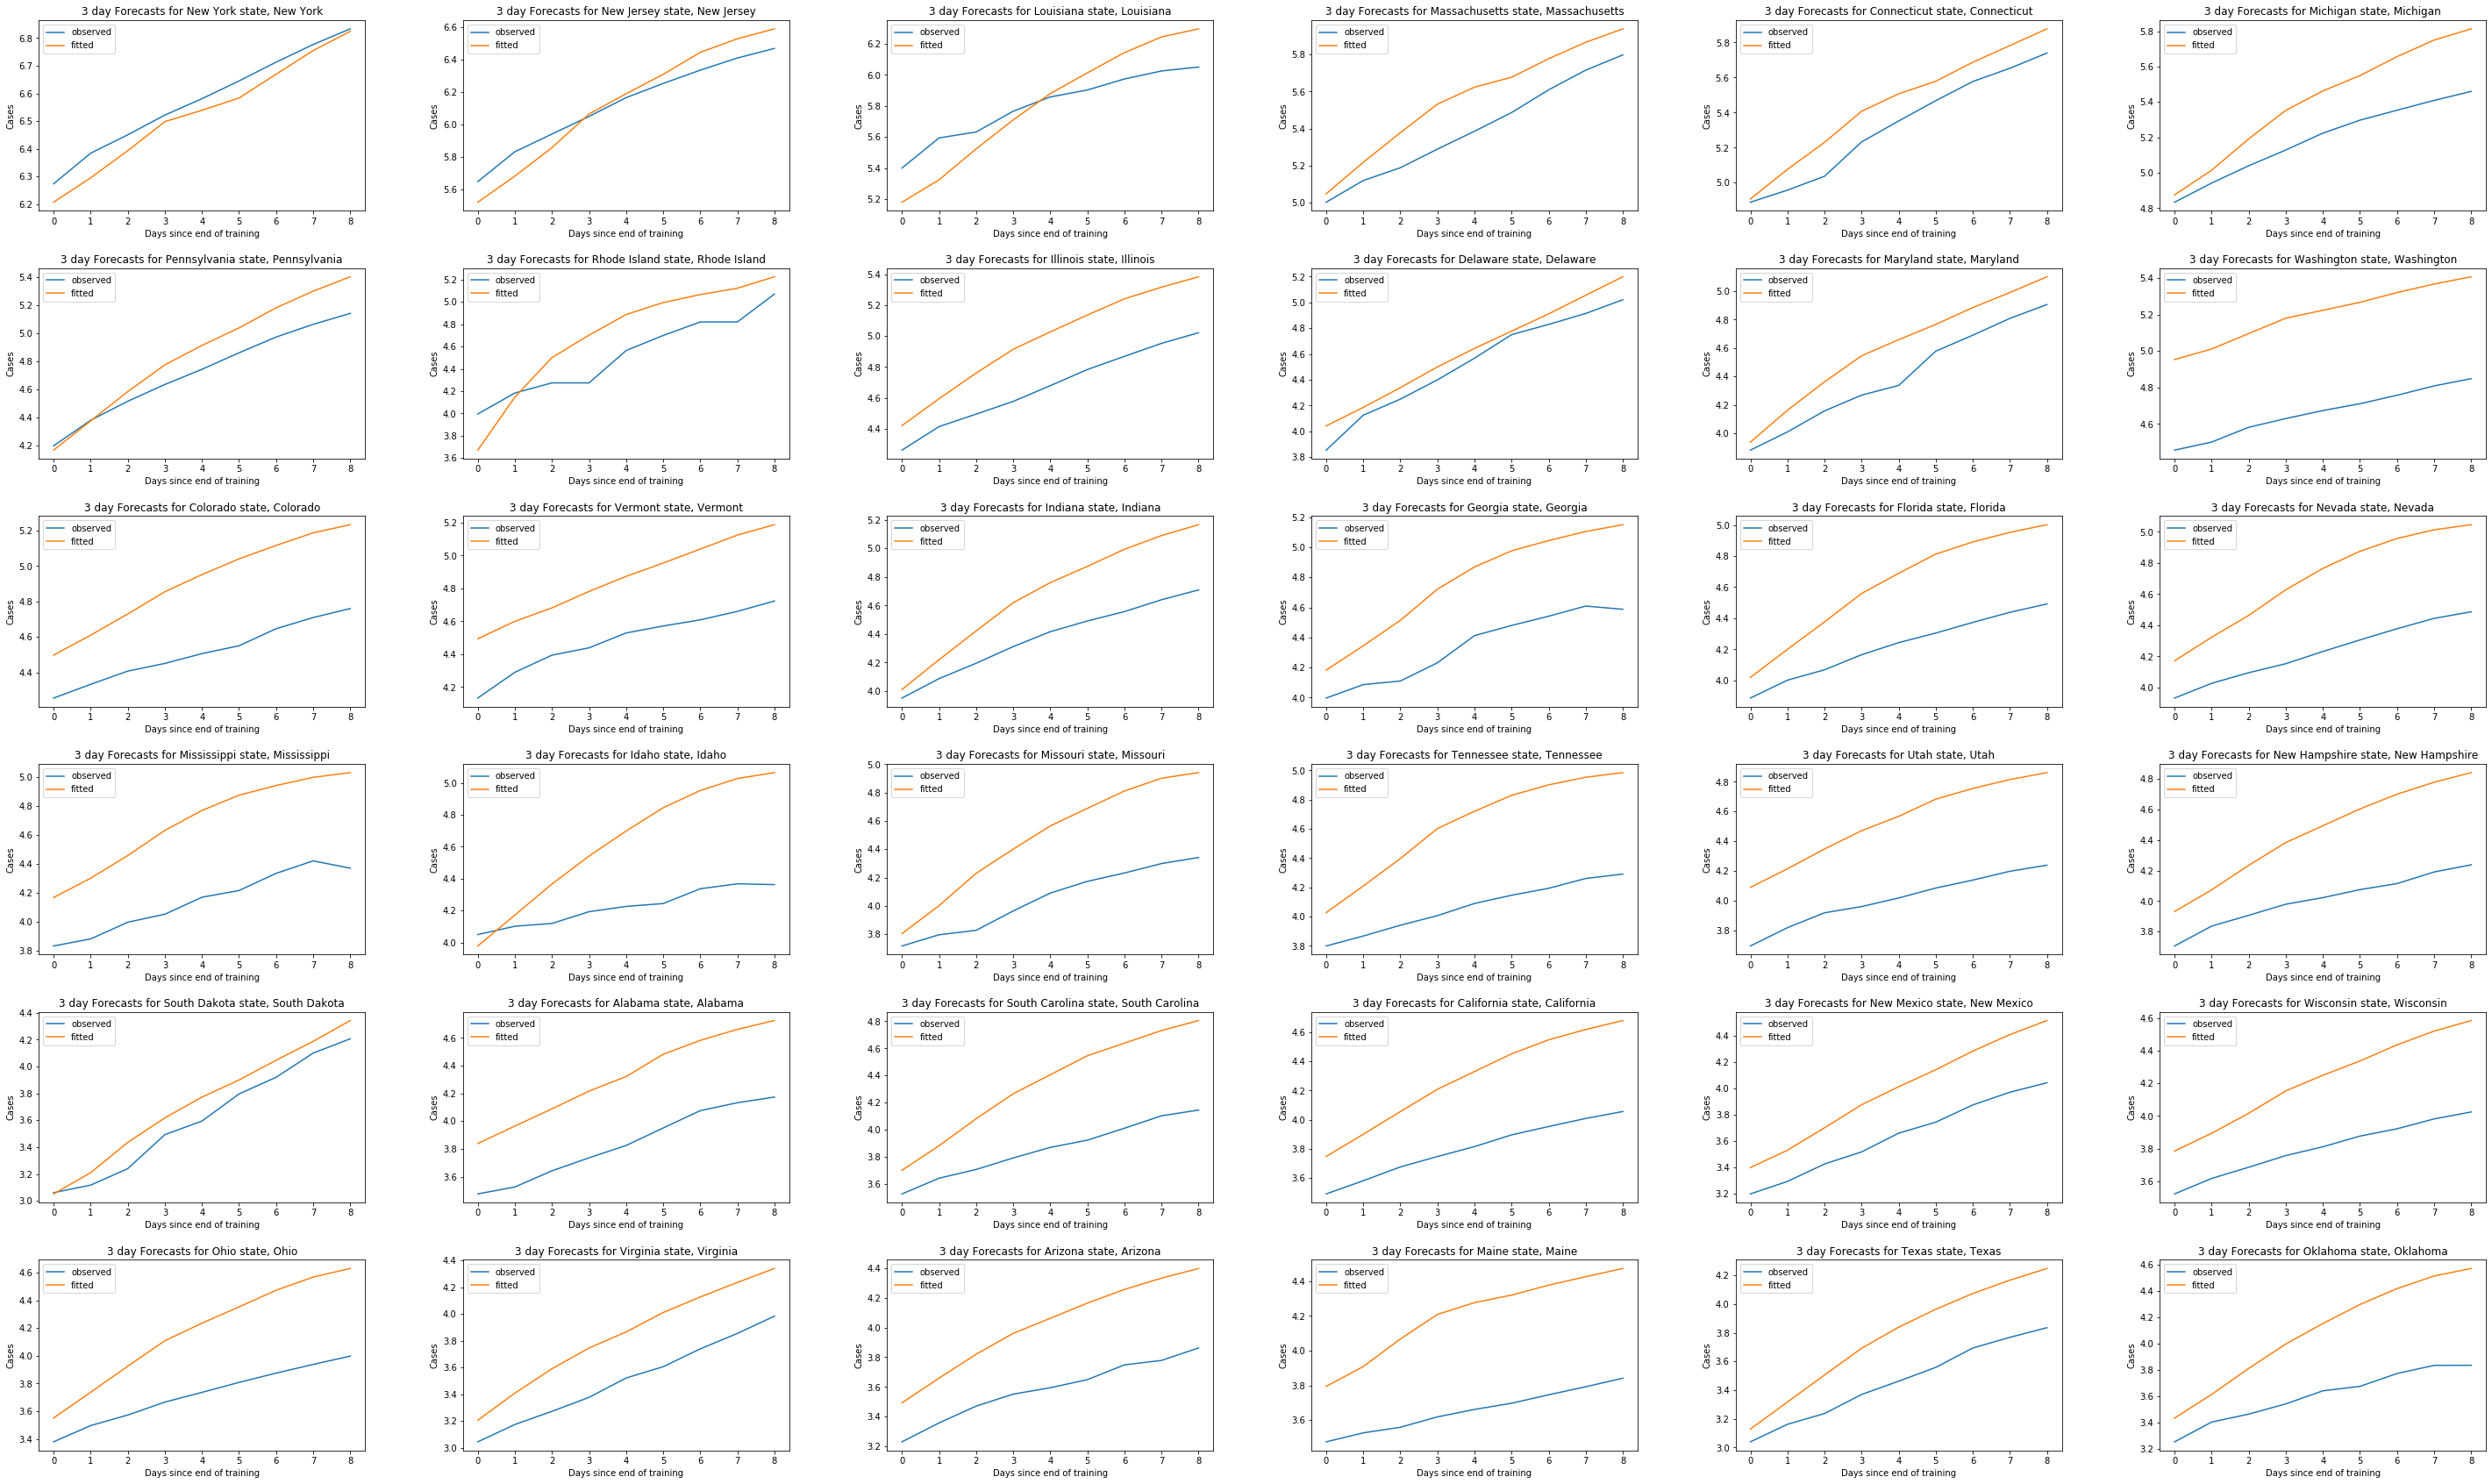

In [142]:
last_day = mobtest[mobtest['date'] == mobtest['date'].max()]
worst_states = last_day.sort_values('casespc', ascending = False)['state']

fig, ax = plt.subplots(6, 6, figsize = (50, 30))
indices = np.random.choice(np.arange(len(statestest)), 36, replace = False)
d = 2

for i, ax in enumerate(ax.ravel()):
    
    state = worst_states.iloc[i] 
    
    statey = ytest[statestest == state]
    stateyhat = yhattest[(statestest == state) & (statestest == state)]
    state_obs = len(statey)

    sns.lineplot(range(state_obs), statey[:,d], label = 'observed', ax = ax)
    sns.lineplot(range(state_obs), stateyhat[:,d], label = 'fitted', ax = ax)
    ax.set(xlabel = 'Days since end of training', ylabel = 'Cases', title = f'{d + 1} day Forecasts for {state} state, {state}');

plt.subplots_adjust(hspace = 0.3, wspace = 0.3)



In [143]:
## Get total score 

## choose how many days ahead to consider (e.g. 3-day forecasts? 1-day forecasts?)
d = 2 # only looking at 3-days-ahead forecasts
# note that this gives multiple observations per county (e.g. one per test-day of NYC)

## get original ytest and yhattest (unlogged)
ytest_dahead_logged = ytest[:,d] # logged ytest
ytest_dahead = np.exp(ytest_dahead_logged) -1 # original counts
yhattest_dahead_logged = yhattest[:,d] # logged yhattest
yhattest_dahead = np.exp(yhattest_dahead_logged) -1 # original counts

## calculate loss!
def mse(true, pred):
    return np.mean( (true - pred)**2 )
mse(ytest_dahead, yhattest_dahead)

1280.295447481061

#### Parameters that worked

    - units = 500
    - interunits = 32 or 100
    - droprate = 0.15
    - tanh, relu, relu (single LSTM layer)
    - lr = 0.00005 or lower 
    - ~10-15 epochs

#### Notes

- Standardize/centralize
- ~Add in other PCS!~
- change MACVAL —opposite effect as expected
- Lag/per capita
- Batch normalization
- batch size
- Change nback
- Add second LSTM layer and lower LR
- add NY back 
- log transfo
- toggle intermediate layer
- try without 0s

Prof. Notes
- Log transform response variable 
- Dynamic training
- Apple mobility? cubiq (?) 